# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [2]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 90.2 MB/s eta 0:

In [3]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [5]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]

# Tokenization	
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


In [7]:
vocabulary_dim=(len(tokenizer.word_index)) #this dictionary maps integers to words. its size is the number of unique tokens
print(vocabulary_dim)
vocabulary_dim=10000

271573


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [8]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data] #it's original data without sos token

Let us look at some examples:

In [9]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 4, 206, 4813, 10, 1336, 51, 9, 550, 5757, 55, 280, 501, 346, 3]
shuffled sentecen:  [2, 55, 4, 280, 4813, 1336, 206, 10, 501, 346, 51, 9, 550, 5757, 3]


Let us look at detokenized data:

In [10]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])



original sentence:  <start> 1780 – american revolution battle of cape st <end>
shuffled sentence:  <start> american st cape 1780 battle revolution – of <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


Depending from the model you plan to build, you might require padding the input sequence

In [12]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [27]:
def get_positional_vector(data, shuffled_data):
    positional_vector = np.zeros((len(data), max_sequence_len))
    for i in range(len(data)): #iterates over sentences
        for j in range(max_sequence_len): #iterates over words (tokens)
            positional_vector[i][j] = np.where(data[i] == shuffled_data[i][j])[0][0]
    return positional_vector

In [28]:
test_positional=get_positional_vector(x_test, c_test)
positional_vector=get_positional_vector(x_train, c_train)

In [15]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

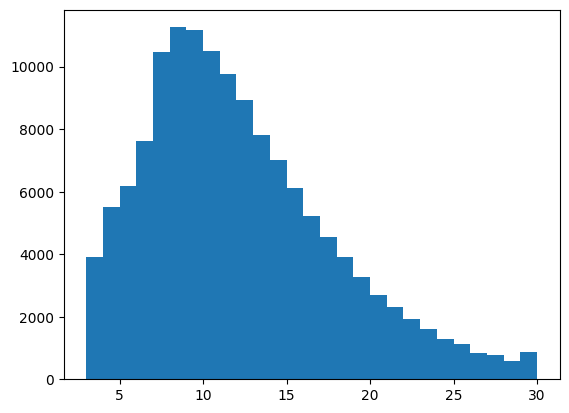

In [16]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [17]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/len(p))

Let's do an example.

In [18]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


In [19]:
print("score taken from dataset:",score(tokenizer.sequences_to_texts([original_data[13]])[0], tokenizer.sequences_to_texts([shuffled_data[13]])[0]))

score taken from dataset: 0.125


The score must be computed as an average of at least 10K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

In [20]:
from tensorflow.keras import backend as K
import tensorflow as tf
def integer_accuracy(y_true, y_pred):
    y_pred_int = tf.cast(y_pred, dtype=tf.int32)
    y_true_int = tf.cast(y_true, dtype=tf.int32)

    #y_pred_int = y_pred.astype(int)
    return K.mean(K.equal(y_true_int, y_pred_int))

In [152]:
from tensorflow.keras.layers import MultiHeadAttention, Reshape, Concatenate, LeakyReLU, Input, Embedding, LSTM, Dense, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW

def getLinearModel(input_dim, embedding_dim=128):
  inputs = Input(shape=(input_dim,))
  embedding = Embedding(input_dim=270000, output_dim=64)(inputs)
  lstm1, _,_ = LSTM(embedding_dim, return_sequences=True, return_state=True, recurrent_dropout=0, activation="tanh")(embedding)
  lstm2, _, _ = LSTM(embedding_dim, return_sequences=True, return_state=True, recurrent_dropout=0, activation="tanh")(lstm1)
  lstm3, _, _ = LSTM(embedding_dim, return_sequences=True,return_state=True, recurrent_dropout=0, activation="tanh")(lstm2)
  attention = MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(lstm3, lstm3)
  x = Concatenate()([lstm3, attention])
  x = Dense(1024, activation=LeakyReLU(alpha=0.1))(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.1))(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation=LeakyReLU(alpha=0.1))(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation=LeakyReLU(alpha=0.1))(x)
  x = Dropout(0.2)(x)
  outputs = Dense(32, activation="softmax")(x)

  model = Model(inputs=inputs, outputs=outputs)
  return model

In [153]:
linearModel=getLinearModel((max_sequence_len))
linearModel.compile(optimizer=AdamW(0.001), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
linearModel.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 embedding_28 (Embedding)       (None, 32, 64)       17280000    ['input_29[0][0]']               
                                                                                                  
 lstm_84 (LSTM)                 [(None, 32, 128),    98816       ['embedding_28[0][0]']           
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                           

In [154]:
linearModel.fit(c_train, onehot_positional, epochs=20, batch_size=128, validation_split=0.1, shuffle=True)


Epoch 1/20
676/676 [==============================] - 64s 80ms/step - loss: 1.6068 - categorical_accuracy: 0.4451 - val_loss: 0.9941 - val_categorical_accuracy: 0.6499
Epoch 2/20
676/676 [==============================] - 29s 43ms/step - loss: 1.3093 - categorical_accuracy: 0.5615 - val_loss: 0.9699 - val_categorical_accuracy: 0.6648
Epoch 3/20
676/676 [==============================] - 27s 39ms/step - loss: 1.3017 - categorical_accuracy: 0.5652 - val_loss: 0.9555 - val_categorical_accuracy: 0.6703
Epoch 4/20
676/676 [==============================] - 27s 40ms/step - loss: 0.9811 - categorical_accuracy: 0.6613 - val_loss: 0.9384 - val_categorical_accuracy: 0.6750
Epoch 5/20
676/676 [==============================] - 27s 40ms/step - loss: 1.4264 - categorical_accuracy: 0.5265 - val_loss: 0.9771 - val_categorical_accuracy: 0.6695
Epoch 6/20
676/676 [==============================] - 26s 38ms/step - loss: 1.1877 - categorical_accuracy: 0.6109 - val_loss: 0.9294 - val_categorical_accuracy:

In [155]:
positional_vector_predictions=linearModel.predict(c_test[0:100])

4/4 [==============================] - 1s 11ms/step


In [158]:
i = np.random.randint(100)
print(np.argmax(positional_vector_predictions[i], axis=-1))
print(test_positional[i].astype(int))

[ 0  4 11 11 11 11  5  3  2  1 11  1 11 13 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14]
[ 0  6  9 10  2 12  6  4  3  1  6  1  7 13 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14]


In [50]:
print(integer_accuracy(test_positional[0:100], positional_vector_predictions))

tf.Tensor(0.33625, shape=(), dtype=float32)


In [49]:
normal_vectors = []
for i in range(len(positional_vector_predictions)): #iterate over sentences
  normal_vector = []
  for j in range(len(c_train[i])): #iterate over words
    normal_vector.append(c_train[i][np.where(positional_vector_predictions[i] == j)[0][0]])
  normal_vectors.append(normal_vector)

IndexError: ignored

In [61]:
from keras.utils import to_categorical
onehot_positional=to_categorical(positional_vector, num_classes=32)

In [62]:
print(onehot_positional[0])

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
